comparison of diagonalization between the models

In [1]:
from HamiltonianClass import Hamiltonian, HamiltonianSandvik
from time import time
from numpy.linalg import eigvalsh
from scipy.sparse.linalg import eigsh
from pympler import asizeof
from matplotlib import pyplot as plt
from CommonFunctions import enhance_plot
import jax.numpy as jnp
import flax.linen as nn
import netket as nk
import numpy as np
import json
# import os
# os.environ["JAX_PLATFORM_NAME"] = "cpu"
%matplotlib inline

Old model

In [2]:
L, J, delta = 14, 1, 1
pbc = True
m = 0

In [3]:
time_start = time()
H_old = Hamiltonian(L=L, J=J, delta=delta, is_pbc=pbc)
H_old.block_concatenation(total_spin=m)
H_old.prepare_hamiltonian()
ground_state_H_old = eigvalsh(H_old.matrix)[0]
time_H_old = time() - time_start
memory_H_old = asizeof.asizeof(H_old.matrix) / 1000
print(f'Ground state for H_old: {ground_state_H_old}\n'
      f'Time: {time_H_old:.4f} seconds\n'
      f'Memory allocated: {memory_H_old:.4f} KB')
del H_old
# H_old.print_matrix()

Ground state for H_old: -6.263549533547024
Time: 3.8375 seconds
Memory allocated: 94229.1360 KB


Newer model

In [4]:
time_start = time()
H_new = HamiltonianSandvik(L=16, J=J, delta=delta, is_pbc=pbc)
H_new.construct_hamiltonian(magnetization=m, convert_indices=True)
ground_state_H_new, _ = eigsh(H_new.get_hamiltonian_as_sparse_matrix(), k=1)
time_H_new = time() - time_start
memory_H_new = asizeof.asizeof(H_new.get_hamiltonian_as_sparse_matrix()) / 1000
print(f'Ground state for H_new: {ground_state_H_new}\n'
      f'Time: {time_H_new:.4f} seconds\n'
      f'Memory allocated: {memory_H_new:.4f} KB')
del H_new
# H_new.print_matrix()

Ground state for H_new: [-7.14229636]
Time: 12.0780 seconds
Memory allocated: 1525.2000 KB


NetKet built-in model (using lanczos method)

In [5]:
time_start = time()
nk_graph = nk.graph.Hypercube(length=18, n_dim=1, pbc=True)
hilbert_space = nk.hilbert.Spin(s=1/2, total_sz=0, N=nk_graph.n_nodes)
H_nk = nk.operator.Heisenberg(hilbert=hilbert_space, graph=nk_graph, sign_rule=False, J=J/4)
ground_state_H_nk = nk.exact.lanczos_ed(H_nk, compute_eigenvectors=False)[0]
time_H_nk = time() - time_start
memory_H_nk = asizeof.asizeof(H_nk) / 1000
print(f'Ground state for H_nk: {ground_state_H_nk}\n'
      f'Time: {time_H_nk:.4f} seconds\n'
      f'Memory allocated: {memory_H_nk:.4f} KB')
# print(H_nk.to_dense())

Ground state for H_nk: -8.02274908703375
Time: 5.7945 seconds
Memory allocated: 3536.9760 KB


Restricted Boltzmann Machine

In [6]:
# hidden unit density
alpha = 2
rbm_model = nk.models.RBM(alpha=alpha)
sampler = nk.sampler.MetropolisExchange(hilbert=hilbert_space, graph=nk_graph)
optimizer = nk.optimizer.Sgd(learning_rate=0.2)
stochastic_reconfiguration = nk.optimizer.SR(diag_shift=1)
v_state = nk.vqs.MCState(sampler, rbm_model, n_samples=1008)
ground_state_loop = nk.VMC(hamiltonian=H_nk, 
                      optimizer=optimizer, 
                      preconditioner=stochastic_reconfiguration, 
                      variational_state=v_state)

In [7]:
start_time = time()
ground_state_loop.run(out='RBM', n_iter=800)
time_H_rbm = time() - start_time

  0%|          | 0/800 [00:00<?, ?it/s]

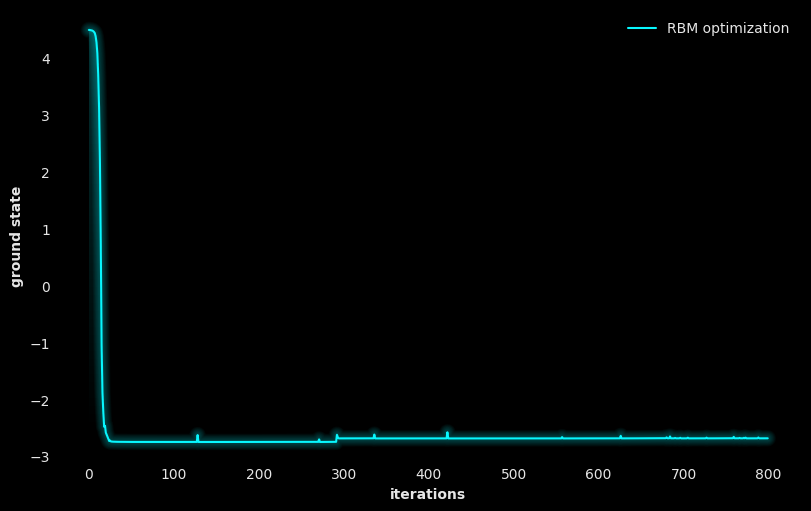

In [8]:
rbm_data = json.load(open('RBM.log'))
iters_rbm, energy_rbm = rbm_data['Energy']['iters'], rbm_data['Energy']['Mean']
with plt.style.context('cyberpunk'):
    fig1, ax1 = plt.subplots(1, 1, layout='constrained', figsize=(8, 5))
    ax1.plot(iters_rbm, energy_rbm, label='RBM optimization')
    ax1.set(xlabel='iterations', ylabel='ground state')
    ax1.grid()
    ax1.legend()
    enhance_plot(fig1, ax1, glow=True, alpha_gradient=0.2)

In [9]:
memory_H_rbm = asizeof.asizeof(v_state) / 1000
ground_state_H_rbm = energy_rbm[-1]
print(f'Ground state for H_rbm: {ground_state_H_rbm}\n'
      f'Time: {time_H_rbm:.4f} seconds\n'
      f'Memory allocated: {memory_H_rbm:.4f} KB')

Ground state for H_rbm: -2.6850345194264342
Time: 44.1055 seconds
Memory allocated: 3524.7680 KB


Feed Forward Neural Network

In [10]:
class FFNN(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(features=2 * x.shape[-1], 
                     param_dtype=np.complex128, 
                     kernel_init=nn.initializers.normal(stddev=0.1),
                     bias_init=nn.initializers.normal(stddev=0.1))(x)
        x = nk.nn.activation.log_cosh(x)
        return jnp.sum(x, axis=-1)

In [11]:
ffnn = FFNN()
v_state_nn = nk.vqs.MCState(sampler, ffnn, n_samples=1008)
ground_state_nn_loop = nk.VMC(hamiltonian=H_nk,
                              optimizer=optimizer,
                              preconditioner=stochastic_reconfiguration,
                              variational_state=v_state_nn)

In [12]:
start_time = time()
ground_state_nn_loop.run(out='FFNN', n_iter=800)
time_H_nn = time() - start_time

  0%|          | 0/800 [00:00<?, ?it/s]

C:\Users\thejg\Desktop\Programming\projects39\lib\site-packages\netket\optimizer\qgt\qgt_onthefly.py:109: HolomorphicUndeclaredWarning: 
Defaulting to `holomorphic=False`, but this might lead to increased
computational cost or disabled features. Check if your variational
function is holomorphic, and if so specify `holomorphic=True`as an extra
keyword argument.

To silence this warning, specify the `holomorphic=False/True` keyword
argument.

To numerically check whether your variational function is or not holomorphic
you can use the following snippet:

```python
   vs = nk.vqs.MCState(...)

   nk.utils.is_probably_holomorphic(vs._apply_fun, vs.parameters, vs.samples, vs.model_state)
```

if `nk.utils.is_probably_holomorphic` returns False, then your function is not holomorphic.
If it returns True, it is probably holomorphic.


-------------------------------------------------------
For more detailed informations, visit the following link:
	 https://netket.readthedocs.io/en/latest/api/_g

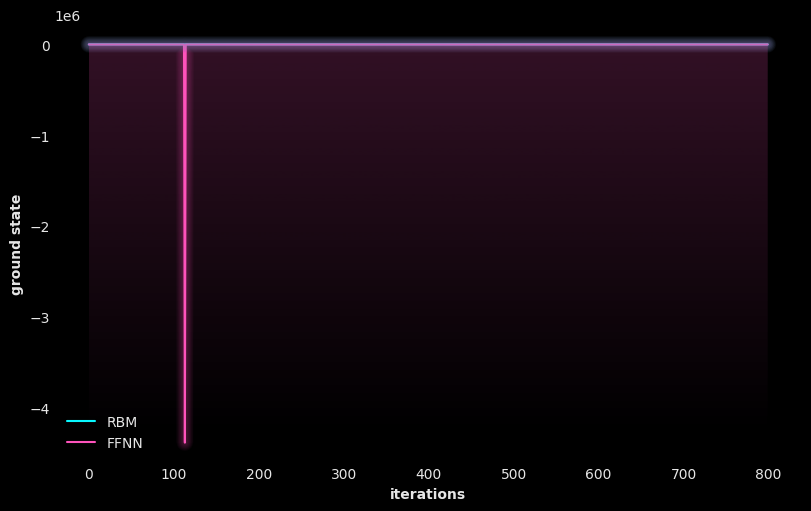

In [13]:
nn_data = json.load(open('FFNN.log'))
iters_nn, energy_nn = nn_data['Energy']['iters'], nn_data['Energy']['Mean']['real']
with plt.style.context('cyberpunk'):
    fig2, ax2 = plt.subplots(1, 1, layout='constrained', figsize=(8, 5))
    ax2.plot(iters_rbm, energy_rbm, label='RBM')
    ax2.plot(iters_nn, energy_nn, label='FFNN')
    ax2.legend()
    ax2.grid()
    ax2.set(xlabel='iterations', ylabel='ground state')
    enhance_plot(fig2, ax2, glow=True, alpha_gradient=0.2)

In [14]:
memory_H_nn = asizeof.asizeof(v_state_nn) / 1000
ground_state_H_nn = energy_nn[-1]
print(f'Ground state for H FFNN: {ground_state_H_nn}\n'
      f'Time: {time_H_nn:.4f} seconds\n'
      f'Memory allocated: {memory_H_nn:.4f} KB')

Ground state for H FFNN: -0.1875
Time: 200.0385 seconds
Memory allocated: 3523.2000 KB


## Performance comparison for different L

In [15]:
L_old = {'L': [], 'time': [], 'memory': [], 'gs': []}
for l in range(2, 13, 2):
    t = time()
    H = Hamiltonian(L=l, J=J, delta=delta, is_pbc=pbc)
    H.block_concatenation(total_spin=0)
    H.prepare_hamiltonian()
    gs = eigvalsh(H.matrix)[0]
    t = time() - t
    mem = round(asizeof.asizeof(H.matrix) / 1000)
    L_old['L'].append(l)
    L_old['time'].append(t)
    L_old['memory'].append(mem)
    L_old['gs'].append(gs)
    del H

In [16]:
L_new = {'L': [], 'time': [], 'memory': [], 'gs': []}
for l in range(2, 15, 2):
    t = time()
    H = HamiltonianSandvik(L=l, J=J, delta=delta, is_pbc=pbc)
    H.construct_hamiltonian(magnetization=m, convert_indices=True)
    sparse = H.get_hamiltonian_as_sparse_matrix()
    gs, _ = eigsh(sparse, k=1)
    gs = gs[0]
    t = time() - t
    mem = round(asizeof.asizeof(sparse) / 1000)
    L_new['L'].append(l)
    L_new['time'].append(t)
    L_new['memory'].append(mem)
    L_new['gs'].append(gs)
del H, sparse

In [17]:
L_nk = {'L': [], 'time': [], 'memory': [], 'gs': []}
for l in range(2, 17, 2):
    for _ in range(2):
        t = time()
        g = nk.graph.Hypercube(length=l, n_dim=1, pbc=pbc)
        hs = nk.hilbert.Spin(s=1/2, total_sz=m, N=g.n_nodes)
        H = nk.operator.Heisenberg(hilbert=hs, graph=g, sign_rule=False, J=J/4)
        gs = nk.exact.lanczos_ed(H, compute_eigenvectors=False)[0]
        t = time() - t
        mem = round(asizeof.asizeof(H) / 1000)
    L_nk['L'].append(l)
    L_nk['time'].append(t)
    L_nk['memory'].append(mem)
    L_nk['gs'].append(gs)
del H, g, hs

In [18]:
L_rbm = {'L': [], 'time': [], 'memory': [], 'gs': []}
for l in range(2, 15, 2):
    g = nk.graph.Hypercube(length=l, n_dim=1, pbc=True)
    hs = nk.hilbert.Spin(s=1/2, total_sz=m, N=g.n_nodes)
    H = nk.operator.Heisenberg(hilbert=hs, graph=g, sign_rule=False, J=J/4)
    rbm = nk.models.RBM(alpha=l / 2)
    sampler = nk.sampler.MetropolisExchange(hilbert=hs, graph=g)
    optimizer = nk.optimizer.Sgd(learning_rate=0.2)
    sr = nk.optimizer.SR(diag_shift=1)
    vs = nk.vqs.MCState(sampler, rbm, n_samples=1008)
    gs_loop = nk.VMC(hamiltonian=H, optimizer=optimizer, preconditioner=sr, variational_state=vs)
    t = time()
    gs_loop.run(out='RBM', n_iter=l*100)
    t = time() - t
    gs = json.load(open('RBM.log'))['Energy']['Mean'][-1]
    mem = asizeof.asizeof(vs) / 1000
    L_rbm['L'].append(l)
    L_rbm['time'].append(t)
    L_rbm['memory'].append(mem)
    L_rbm['gs'].append(gs)
del g, hs, H, vs, gs_loop

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

  0%|          | 0/1400 [00:00<?, ?it/s]

In [19]:
L_nn = {'L': [], 'time': [], 'memory': [], 'gs': []}
for l in range(2, 15, 2):
    g = nk.graph.Hypercube(length=l, n_dim=1, pbc=True)
    hs = nk.hilbert.Spin(s=1/2, total_sz=m, N=g.n_nodes)
    H = nk.operator.Heisenberg(hilbert=hs, graph=g, sign_rule=False, J=J/4)
    ffnn = FFNN()
    sampler = nk.sampler.MetropolisExchange(hilbert=hs, graph=g)
    optimizer = nk.optimizer.Sgd(learning_rate=0.2)
    sr = nk.optimizer.SR(diag_shift=1)
    vs = nk.vqs.MCState(sampler, ffnn, n_samples=1008)
    gs_loop = nk.VMC(hamiltonian=H, optimizer=optimizer, preconditioner=sr, variational_state=vs)
    t = time()
    gs_loop.run(out='FFNN', n_iter=l*100)
    t = time() - t
    gs = json.load(open('FFNN.log'))['Energy']['Mean']['real'][-1]
    mem = asizeof.asizeof(vs) / 1000
    L_nn['L'].append(l)
    L_nn['time'].append(t)
    L_nn['memory'].append(mem)
    L_nn['gs'].append(gs)
del g, hs, H, vs, gs_loop

  0%|          | 0/200 [00:00<?, ?it/s]

C:\Users\thejg\Desktop\Programming\projects39\lib\site-packages\netket\optimizer\qgt\qgt_onthefly.py:109: HolomorphicUndeclaredWarning: 
Defaulting to `holomorphic=False`, but this might lead to increased
computational cost or disabled features. Check if your variational
function is holomorphic, and if so specify `holomorphic=True`as an extra
keyword argument.

To silence this warning, specify the `holomorphic=False/True` keyword
argument.

To numerically check whether your variational function is or not holomorphic
you can use the following snippet:

```python
   vs = nk.vqs.MCState(...)

   nk.utils.is_probably_holomorphic(vs._apply_fun, vs.parameters, vs.samples, vs.model_state)
```

if `nk.utils.is_probably_holomorphic` returns False, then your function is not holomorphic.
If it returns True, it is probably holomorphic.


-------------------------------------------------------
For more detailed informations, visit the following link:
	 https://netket.readthedocs.io/en/latest/api/_g

  0%|          | 0/400 [00:00<?, ?it/s]

C:\Users\thejg\Desktop\Programming\projects39\lib\site-packages\netket\optimizer\qgt\qgt_onthefly.py:109: HolomorphicUndeclaredWarning: 
Defaulting to `holomorphic=False`, but this might lead to increased
computational cost or disabled features. Check if your variational
function is holomorphic, and if so specify `holomorphic=True`as an extra
keyword argument.

To silence this warning, specify the `holomorphic=False/True` keyword
argument.

To numerically check whether your variational function is or not holomorphic
you can use the following snippet:

```python
   vs = nk.vqs.MCState(...)

   nk.utils.is_probably_holomorphic(vs._apply_fun, vs.parameters, vs.samples, vs.model_state)
```

if `nk.utils.is_probably_holomorphic` returns False, then your function is not holomorphic.
If it returns True, it is probably holomorphic.


-------------------------------------------------------
For more detailed informations, visit the following link:
	 https://netket.readthedocs.io/en/latest/api/_g

  0%|          | 0/600 [00:00<?, ?it/s]

C:\Users\thejg\Desktop\Programming\projects39\lib\site-packages\netket\optimizer\qgt\qgt_onthefly.py:109: HolomorphicUndeclaredWarning: 
Defaulting to `holomorphic=False`, but this might lead to increased
computational cost or disabled features. Check if your variational
function is holomorphic, and if so specify `holomorphic=True`as an extra
keyword argument.

To silence this warning, specify the `holomorphic=False/True` keyword
argument.

To numerically check whether your variational function is or not holomorphic
you can use the following snippet:

```python
   vs = nk.vqs.MCState(...)

   nk.utils.is_probably_holomorphic(vs._apply_fun, vs.parameters, vs.samples, vs.model_state)
```

if `nk.utils.is_probably_holomorphic` returns False, then your function is not holomorphic.
If it returns True, it is probably holomorphic.


-------------------------------------------------------
For more detailed informations, visit the following link:
	 https://netket.readthedocs.io/en/latest/api/_g

  0%|          | 0/800 [00:00<?, ?it/s]

C:\Users\thejg\Desktop\Programming\projects39\lib\site-packages\netket\optimizer\qgt\qgt_onthefly.py:109: HolomorphicUndeclaredWarning: 
Defaulting to `holomorphic=False`, but this might lead to increased
computational cost or disabled features. Check if your variational
function is holomorphic, and if so specify `holomorphic=True`as an extra
keyword argument.

To silence this warning, specify the `holomorphic=False/True` keyword
argument.

To numerically check whether your variational function is or not holomorphic
you can use the following snippet:

```python
   vs = nk.vqs.MCState(...)

   nk.utils.is_probably_holomorphic(vs._apply_fun, vs.parameters, vs.samples, vs.model_state)
```

if `nk.utils.is_probably_holomorphic` returns False, then your function is not holomorphic.
If it returns True, it is probably holomorphic.


-------------------------------------------------------
For more detailed informations, visit the following link:
	 https://netket.readthedocs.io/en/latest/api/_g

  0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\thejg\Desktop\Programming\projects39\lib\site-packages\netket\optimizer\qgt\qgt_onthefly.py:109: HolomorphicUndeclaredWarning: 
Defaulting to `holomorphic=False`, but this might lead to increased
computational cost or disabled features. Check if your variational
function is holomorphic, and if so specify `holomorphic=True`as an extra
keyword argument.

To silence this warning, specify the `holomorphic=False/True` keyword
argument.

To numerically check whether your variational function is or not holomorphic
you can use the following snippet:

```python
   vs = nk.vqs.MCState(...)

   nk.utils.is_probably_holomorphic(vs._apply_fun, vs.parameters, vs.samples, vs.model_state)
```

if `nk.utils.is_probably_holomorphic` returns False, then your function is not holomorphic.
If it returns True, it is probably holomorphic.


-------------------------------------------------------
For more detailed informations, visit the following link:
	 https://netket.readthedocs.io/en/latest/api/_g

  0%|          | 0/1200 [00:00<?, ?it/s]

C:\Users\thejg\Desktop\Programming\projects39\lib\site-packages\netket\optimizer\qgt\qgt_onthefly.py:109: HolomorphicUndeclaredWarning: 
Defaulting to `holomorphic=False`, but this might lead to increased
computational cost or disabled features. Check if your variational
function is holomorphic, and if so specify `holomorphic=True`as an extra
keyword argument.

To silence this warning, specify the `holomorphic=False/True` keyword
argument.

To numerically check whether your variational function is or not holomorphic
you can use the following snippet:

```python
   vs = nk.vqs.MCState(...)

   nk.utils.is_probably_holomorphic(vs._apply_fun, vs.parameters, vs.samples, vs.model_state)
```

if `nk.utils.is_probably_holomorphic` returns False, then your function is not holomorphic.
If it returns True, it is probably holomorphic.


-------------------------------------------------------
For more detailed informations, visit the following link:
	 https://netket.readthedocs.io/en/latest/api/_g

  0%|          | 0/1400 [00:00<?, ?it/s]

C:\Users\thejg\Desktop\Programming\projects39\lib\site-packages\netket\optimizer\qgt\qgt_onthefly.py:109: HolomorphicUndeclaredWarning: 
Defaulting to `holomorphic=False`, but this might lead to increased
computational cost or disabled features. Check if your variational
function is holomorphic, and if so specify `holomorphic=True`as an extra
keyword argument.

To silence this warning, specify the `holomorphic=False/True` keyword
argument.

To numerically check whether your variational function is or not holomorphic
you can use the following snippet:

```python
   vs = nk.vqs.MCState(...)

   nk.utils.is_probably_holomorphic(vs._apply_fun, vs.parameters, vs.samples, vs.model_state)
```

if `nk.utils.is_probably_holomorphic` returns False, then your function is not holomorphic.
If it returns True, it is probably holomorphic.


-------------------------------------------------------
For more detailed informations, visit the following link:
	 https://netket.readthedocs.io/en/latest/api/_g

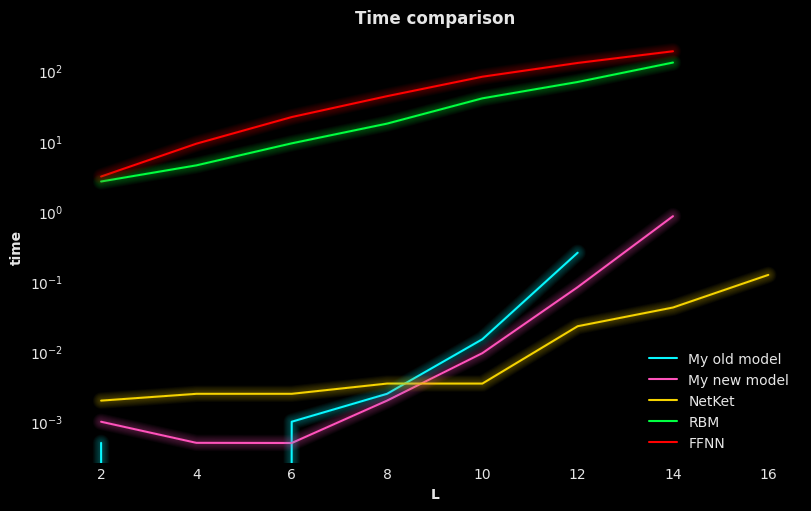

In [24]:
model_names = ['My old model', 'My new model', 'NetKet', 'RBM', 'FFNN']
models = [L_old, L_new, L_nk, L_rbm, L_nn]
with plt.style.context('cyberpunk'):
    fig3, ax3 = plt.subplots(1, 1, layout='constrained', figsize=(8, 5))
    for L_data, name in zip(models, model_names):
        ax3.plot(L_data['L'], L_data['time'], label=f'{name}')
    ax3.set(title='Time comparison', xlabel='L', ylabel='time', yscale='log')
    ax3.legend()
    ax3.grid()
    enhance_plot(fig3, ax3, glow=True)

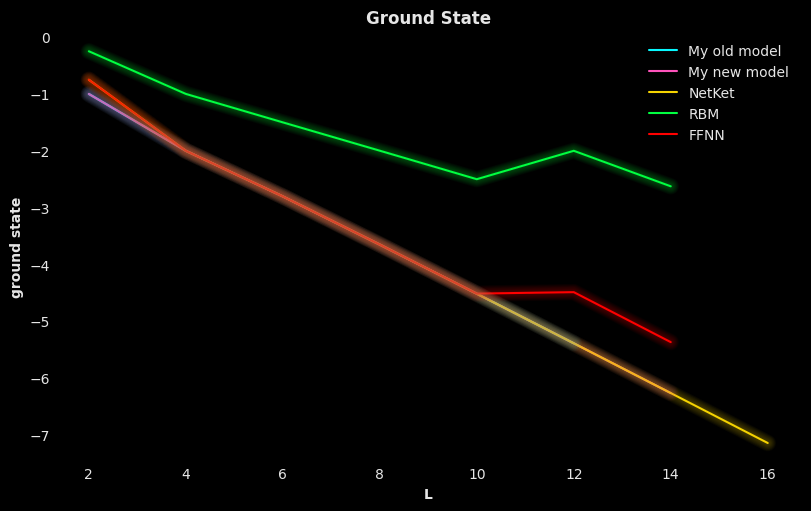

In [21]:
with plt.style.context('cyberpunk'):
    fig3, ax3 = plt.subplots(1, 1, layout='constrained', figsize=(8, 5))
    for L_data, name in zip(models, model_names):
        ax3.plot(L_data['L'], L_data['gs'], label=f'{name}')
    ax3.legend()
    ax3.grid()
    ax3.set(title='Ground State', xlabel='L', ylabel='ground state')
    enhance_plot(fig3, ax3, glow=True)

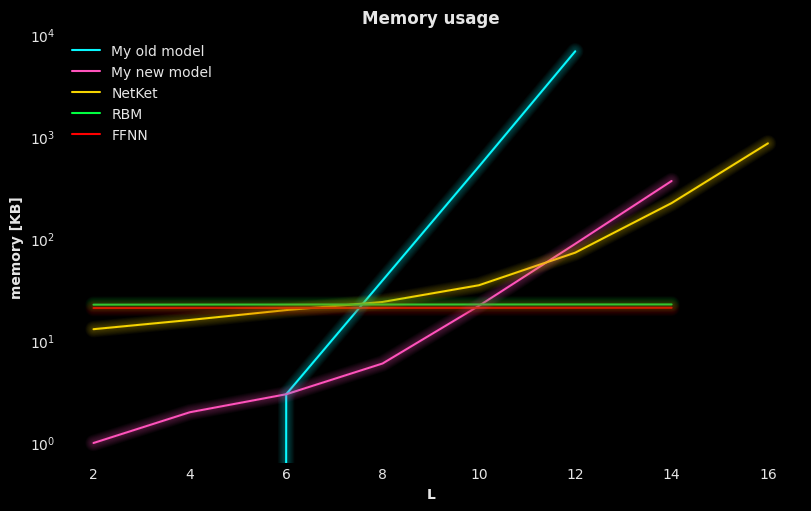

In [25]:
with plt.style.context('cyberpunk'):
    fig3, ax3 = plt.subplots(1, 1, layout='constrained', figsize=(8, 5))
    for L_data, name in zip(models, model_names):
        ax3.plot(L_data['L'], L_data['memory'], label=f'{name}')
    ax3.legend()
    ax3.grid()
    ax3.set(title='Memory usage', xlabel='L', ylabel='memory [KB]', yscale='log')
    enhance_plot(fig3, ax3, glow=True)